In [4]:
import sys
print(sys.executable)

/home/fatnaoui/tools/miniforge3/envs/fasttext/bin/python


In [5]:
from datasets import load_dataset
from pathlib import Path
import json
import random
import re
from tqdm import tqdm

from helpers.filtering import looks_like_clean_generic, remove_invisible_chars

In [7]:
# build_other_latin.py

from datasets import load_dataset
from pathlib import Path
from tqdm import tqdm
import json
import re  # needed only if you tweak sentence_split here

from helpers.filtering import (
    remove_invisible_chars,
    looks_like_clean_generic,
    sentence_split,
)

# ========= CONFIG =========

OTHER_WIKI_LATIN_LANGS = [
    "de",  # German
    "pt",  # Portuguese
    "nl",  # Dutch
    "sv",  # Swedish
    "da",  # Danish
    "no",  # Norwegian
    "ro",  # Romanian
    "ca",  # Catalan
]

out_file = Path("other_data.jsonl")

TARGET_TOTAL_SENTENCES = 20_000   # total from all these langs
TARGET_PER_LANG        = 9_000    # max per language
MIN_WORDS              = 3        # min words per sentence

# ==========================

n_total_sentences = 0

with out_file.open("w", encoding="utf-8") as f_out:
    for lang in OTHER_WIKI_LATIN_LANGS:
        # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
        #     break

        print(f"\n=== Processing language: {lang} ===")

        # stream Wikipedia to avoid loading all in RAM
        dataset = load_dataset(
            "wikimedia/wikipedia",
            f"20231101.{lang}",
            split="train",
            streaming=True,
        )

        n_lang_sentences = 0

        for example in tqdm(dataset, desc=f"{lang} articles"):
            # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
            #     break
            if n_lang_sentences >= TARGET_PER_LANG:
                break

            text = example.get("text", None)
            if not text:
                continue

            # Split article into sentences
            sentences = sentence_split(text)

            for sent in sentences:
                # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
                #     break
                if n_lang_sentences >= TARGET_PER_LANG:
                    break

                sent = sent.strip()
                if not sent:
                    continue

                sent = remove_invisible_chars(sent)
                sent = re.sub(r"\s+", " ", sent)
                if not sent:
                    continue

                if not looks_like_clean_generic(
                    sent,
                    min_words=MIN_WORDS,
                    max_digit_ratio=0.5,
                ):
                    continue

                # keep original case for OTHER
                line = json.dumps(
                    {"text": sent},
                    ensure_ascii=False,
                )
                f_out.write(line + "\n")

                n_lang_sentences += 1
                n_total_sentences += 1

        print(f"Collected {n_lang_sentences} sentences for language '{lang}'.")

print(f"\nDone. Total OTHER_LATIN sentences: {n_total_sentences}")
print(f"Saved to: {out_file}")



=== Processing language: de ===


de articles: 66it [00:16,  4.11it/s]


Collected 9000 sentences for language 'de'.

=== Processing language: pt ===


pt articles: 54it [00:29,  1.81it/s]


Collected 9000 sentences for language 'pt'.

=== Processing language: nl ===


nl articles: 84it [00:19,  4.25it/s]


Collected 9000 sentences for language 'nl'.

=== Processing language: sv ===


sv articles: 147it [00:25,  5.76it/s]


Collected 9000 sentences for language 'sv'.

=== Processing language: da ===


da articles: 146it [00:21,  6.65it/s]


Collected 9000 sentences for language 'da'.

=== Processing language: no ===


no articles: 90it [00:27,  3.29it/s]


Collected 9000 sentences for language 'no'.

=== Processing language: ro ===


ro articles: 66it [00:25,  2.58it/s]


Collected 9000 sentences for language 'ro'.

=== Processing language: ca ===


ca articles: 94it [00:26,  3.61it/s]

Collected 9000 sentences for language 'ca'.

Done. Total OTHER_LATIN sentences: 72000
Saved to: other_data.jsonl


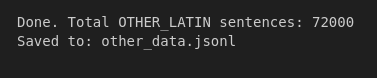
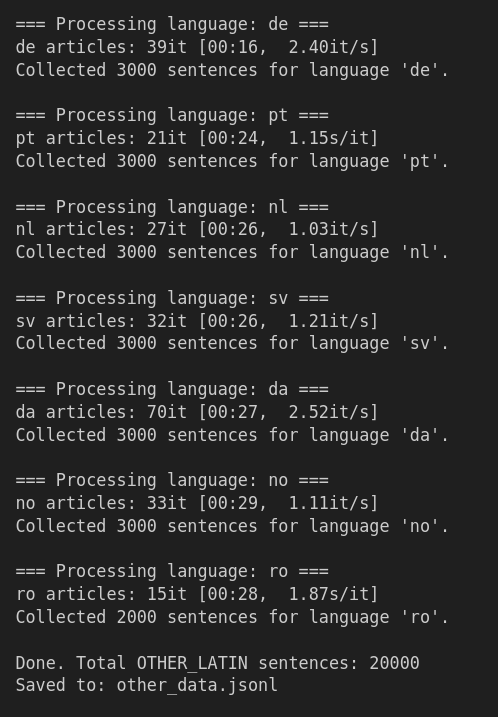

In [8]:
import unicodedata
import re

# Unicode ranges per script
SCRIPT_RANGES = {
    "ru": [  # Cyrillic
        (0x0400, 0x04FF),
    ],
    "zh": [  # CJK Unified Ideographs (very rough but good enough)
        (0x4E00, 0x9FFF),
    ],
    "hi": [  # Devanagari
        (0x0900, 0x097F),
    ],
    "he": [  # Hebrew
        (0x0590, 0x05FF),
    ],
}

# Minimum ratio of chars that must belong to the script
SCRIPT_MIN_RATIO = {
    "ru": 0.40,  # Russian often mixes digits/latin; 40% is reasonable
    "zh": 0.50,  # Chinese: usually a lot of Han chars
    "hi": 0.50,
    "he": 0.50,
}


INVISIBLE_CATEGORIES = {"Cf", "Cc"}  # format & control chars

def _in_ranges(ch: str, ranges) -> bool:
    cp = ord(ch)
    for start, end in ranges:
        if start <= cp <= end:
            return True
    return False


def script_ratio(text: str, lang: str) -> float:
    """
    Approximate ratio of characters that belong to the expected script
    for a given language code (ru, zh, hi, he).
    """
    ranges = SCRIPT_RANGES.get(lang)
    if not ranges:
        # If we don't know the script, say ratio = 1.0 (no filtering)
        return 1.0

    script_count = 0
    relevant_count = 0

    for ch in text:
        # Skip spaces
        if ch.isspace():
            continue

        cat = unicodedata.category(ch)
        # Skip punctuation and symbols, focus on letters/digits
        if cat.startswith("P") or cat.startswith("S"):
            continue

        relevant_count += 1
        if _in_ranges(ch, ranges):
            script_count += 1

    if relevant_count == 0:
        return 0.0

    return script_count / relevant_count

def is_mostly_lang_script(text: str, lang: str) -> bool:
    ratio = script_ratio(text, lang)
    min_ratio = SCRIPT_MIN_RATIO.get(lang, 0.0)
    return ratio >= min_ratio

is_mostly_lang_script("hello hello", "ru")

False

In [9]:
def sentence_split_multiscript(text: str):
    """
    Sentence splitter that works for multiple scripts:
    - Latin punctuation: . ! ?
    - Arabic question mark: ؟
    - CJK punctuation: 。 ！ ？
    """
    return re.split(r'(?<=[\.\!\?؟。！？])\s*', text)

OTHER_WIKI_NONLATIN_LANGS = [
    "ru",  # Russian (Cyrillic)
    "zh",  # Chinese
    "hi",  # Hindi (Devanagari)
    "he",  # Hebrew
]

out_file = Path("other1_data.jsonl")

TARGET_TOTAL_SENTENCES = 12_000   # total from all these langs (adjust as you like)
TARGET_PER_LANG        = 9_000    # max per language
MIN_WORDS              = 3        # min words per sentence

# ==========================

n_total_sentences = 0

with out_file.open("w", encoding="utf-8") as f_out:
    for lang in OTHER_WIKI_NONLATIN_LANGS:
        # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
        #     break

        print(f"\n=== Processing non-Latin language: {lang} ===")

        dataset = load_dataset(
            "wikimedia/wikipedia",
            f"20231101.{lang}",
            split="train",
            streaming=True,
        )

        n_lang_sentences = 0

        for example in tqdm(dataset, desc=f"{lang} articles"):
            # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
            #     break
            if n_lang_sentences >= TARGET_PER_LANG:
                break

            text = example.get("text", None)
            if not text:
                continue

            # Split article into sentences
            sentences = sentence_split_multiscript(text)

            for sent in sentences:
                # if n_total_sentences >= TARGET_TOTAL_SENTENCES:
                #     break
                if n_lang_sentences >= TARGET_PER_LANG:
                    break

                sent = sent.strip()
                if not sent:
                    continue

                sent = remove_invisible_chars(sent)
                sent = re.sub(r"\s+", " ", sent)
                if not sent:
                    continue

                if not is_mostly_lang_script(sent, lang):
                    continue

                if not looks_like_clean_generic(
                    sent,
                    min_words=MIN_WORDS,
                    max_digit_ratio=0.7,
                ):
                    continue

                # Keep original case for OTHER
                line = json.dumps(
                    {"text": sent},
                    ensure_ascii=False,
                )
                f_out.write(line + "\n")

                n_lang_sentences += 1
                n_total_sentences += 1

        print(f"Collected {n_lang_sentences} sentences for language '{lang}'.")

print(f"\nDone. Total OTHER_NONLATIN sentences: {n_total_sentences}")
print(f"Saved to: {out_file}")


=== Processing non-Latin language: ru ===


ru articles: 19it [00:21,  1.11s/it]


Collected 9000 sentences for language 'ru'.

=== Processing non-Latin language: zh ===


zh articles: 1798it [00:47, 37.68it/s] 


Collected 9000 sentences for language 'zh'.

=== Processing non-Latin language: hi ===


hi articles: 1327it [00:46, 28.27it/s] 


Collected 9000 sentences for language 'hi'.

=== Processing non-Latin language: he ===


he articles: 126it [00:19,  6.57it/s]

Collected 9000 sentences for language 'he'.

Done. Total OTHER_NONLATIN sentences: 36000
Saved to: other1_data.jsonl


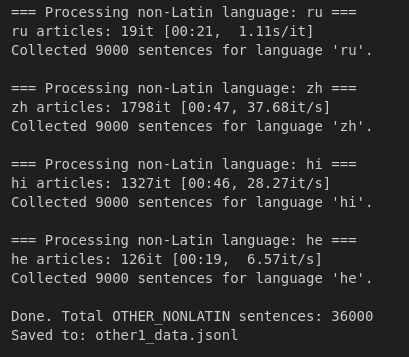
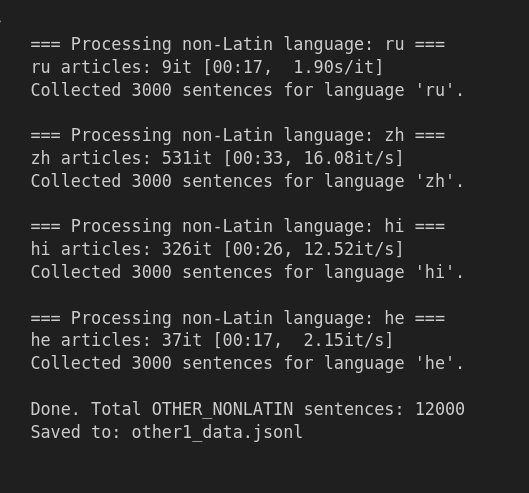
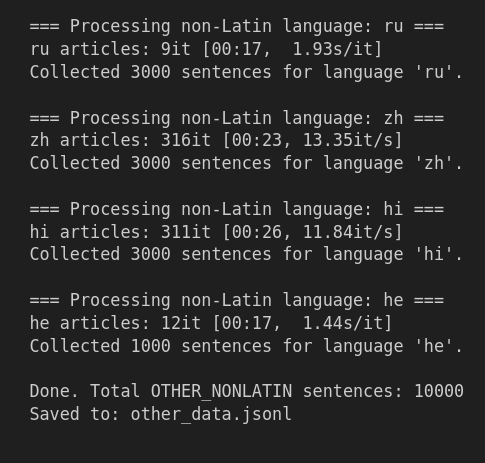

In [10]:
# egypt latin

import re

def contains_arabic_letters(s: str) -> bool:
    """Return True if there is at least one Arabic script character."""
    for ch in s:
        if '\u0600' <= ch <= '\u06FF':
            return True
    return False

from datasets import load_dataset
from pathlib import Path
from tqdm import tqdm
import json
import re

# ---------- CONFIG ----------

# (short_code, HF dataset name)
ARABIC_DIALECT_SOURCES = [
    ("egy",  "Omartificial-Intelligence-Space/FineWeb2-Egyptian-Arabic"),
    ("nlev", "Omartificial-Intelligence-Space/FineWeb2-North-Levantine-Arabic"),
]

out_file = Path("other2_data.jsonl")   # SAME file as your other 'other' blocks

TARGET_SENTENCES_TOTAL = 6_000       # total from ALL dialects (tune)
TARGET_PER_DIALECT    = 25_000         # max per dialect
MIN_WORDS             = 3
MAX_DIGIT_RATIO       = 0.3           # allow some numbers but not too many

# ---------- MAIN ----------

n_total_sentences = 0

# IMPORTANT: append mode, we assume other_data.jsonl already exists
with out_file.open("w", encoding="utf-8") as f_out:

    for dialect_code, hf_name in ARABIC_DIALECT_SOURCES:
        # if n_total_sentences >= TARGET_SENTENCES_TOTAL:
        #     break

        print(f"\n=== Processing Arabic dialect: {dialect_code} from {hf_name} ===")

        # stream to avoid loading everything in RAM
        dataset = load_dataset(
            hf_name,
            split="train",
            streaming=True,
        )

        n_dialect_sentences = 0

        for example in tqdm(dataset, desc=f"{dialect_code} docs"):
            # if n_total_sentences >= TARGET_SENTENCES_TOTAL:
            #     break
            if n_dialect_sentences >= TARGET_PER_DIALECT:
                break

            text = example.get("text", None)
            if not text:
                continue

            # split into sentences
            sentences = sentence_split_multiscript(text)

            for sent in sentences:
                # if n_total_sentences >= TARGET_SENTENCES_TOTAL:
                #     break
                if n_dialect_sentences >= TARGET_PER_DIALECT:
                    break

                sent = sent.strip()
                if not sent:
                    continue

                # must contain Arabic script → avoid English noise in the corpus
                if not contains_arabic_letters(sent):
                    continue

                # clean invisibles + whitespace
                sent = remove_invisible_chars(sent)
                sent = re.sub(r"\s+", " ", sent)
                if not sent:
                    continue

                # generic quality filter
                if not looks_like_clean_generic(
                    sent,
                    min_words=MIN_WORDS,
                    max_digit_ratio=MAX_DIGIT_RATIO,
                ):
                    continue

                # keep original case for Arabic, just remove newlines
                sent = sent.replace("\n", " ")

                # store source info for analysis/debug (but training label will be `other`)
                line = json.dumps(
                    {
                        "text": sent,
                    },
                    ensure_ascii=False,
                )
                f_out.write(line + "\n")

                n_dialect_sentences += 1
                n_total_sentences += 1

        print(f"Collected {n_dialect_sentences} sentences for dialect '{dialect_code}'.")

print(f"\nDone. Total OTHER Arabic-dialect sentences appended: {n_total_sentences}")
print(f"Appended to: {out_file}")



=== Processing Arabic dialect: egy from Omartificial-Intelligence-Space/FineWeb2-Egyptian-Arabic ===


egy docs: 17619it [00:29, 591.63it/s] 


Collected 25000 sentences for dialect 'egy'.

=== Processing Arabic dialect: nlev from Omartificial-Intelligence-Space/FineWeb2-North-Levantine-Arabic ===


nlev docs: 26517it [00:12, 2112.82it/s]

Collected 25000 sentences for dialect 'nlev'.

Done. Total OTHER Arabic-dialect sentences appended: 50000
Appended to: other2_data.jsonl


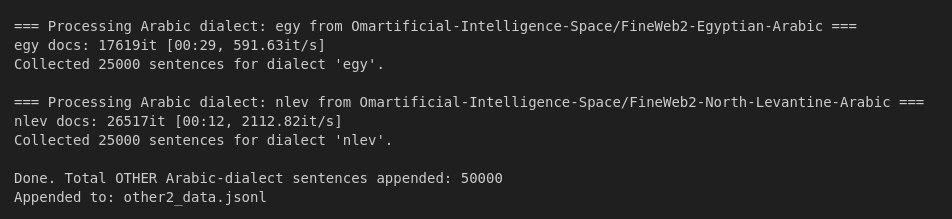
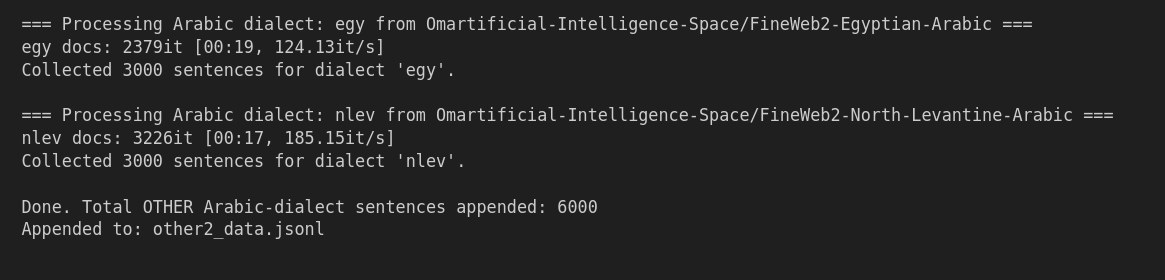

In [17]:
# Do this in the terminal
!hf auth login

User is already logged in.


In [20]:
# other arabizi

import re
import unicodedata

INVISIBLE_CATEGORIES = {"Cf", "Cc"}  # same as before

def remove_invisible_chars(s: str) -> str:
    s = s.replace('\u00A0', ' ')   # no-break space -> normal space
    s = ''.join(
        ch for ch in s
        if unicodedata.category(ch) not in INVISIBLE_CATEGORIES
    )
    s = re.sub(r'\s+', ' ', s).strip()
    return s


def looks_like_arabizi_pure_latin(s: str, min_ratio=0.9) -> bool:
    """
    Generic Arabizi-like filter:
    - only latin letters, digits and simple punctuation
    - no Arabic script
    - at least one digit (2,3,5,6,7,8,9) typical of Arabizi
    """
    if not s:
        return False

    s = s.strip().lower()

    # Reject if Arabic script appears
    if any('\u0600' <= ch <= '\u06FF' for ch in s):
        return False

    allowed = set("abcdefghijklmnopqrstuvwxyz0123456789 '!?.,:;()-")
    good = sum(ch in allowed for ch in s)
    ratio = good / max(len(s), 1)

    if ratio < min_ratio:
        return False

    # require at least one Arabizi-style digit
    if not any(d in s for d in "2356789"):
        return False

    # avoid super short junk (e.g. "lol", "xd")
    if len(s.split()) < 2:
        return False

    return True


from pathlib import Path
from datasets import load_dataset
from tqdm import tqdm
import json
import re

out_file = Path("other3_data.jsonl")

min_words = 3
TARGET_SENTENCES = 25_000   # e.g. 25k Egy + 25k Lev, adjust as you like
TARGET_SENTENCES_PER_LANGUAGE = 25_000

n_examples = 0
n_sentences = 0
n_words = 0


def iter_egy_arabizi():

    ds = load_dataset("UBC-NLP/nilechat-arabizi-egy", split="train", streaming=True)
    for ex in ds:
        # TODO: adapt this field name.
        # Common guesses: "text", "arabizi", "content"
        text = (
            ex.get("text")
        )
        if text:
            yield text


def iter_lev_arabizi():
    """
    Levantine Arabizi from palmaoui/AladdinBench
    (after you accept the conditions on HF).
    Again, inspect columns once and adapt.
    """
    ds = load_dataset("palmaoui/AladdinBench", split="train", streaming=True)
    for ex in ds:
        # TODO: adapt this field name.
        # Likely something like "arabizi" or "source"
        text = (
            ex.get("text")
        )
        if text:
            yield text


def iter_all_texts():

    # first Egypt
    # for t in iter_egy_arabizi():
    #     yield t

    # # then Levantine
    for t in iter_lev_arabizi():
        yield t


with out_file.open("a", encoding="utf-8") as f_out:
    for raw_text in tqdm(iter_all_texts(), desc="Building OTHER_LATN Arabizi (Egy+Lev)"):

        if n_sentences >= TARGET_SENTENCES:
            break

        if not raw_text:
            continue

        # split into sentence-like chunks
        sentences = re.split(r'(?<=[\.\?!])\s+', raw_text)

        for sent in sentences:
            if n_sentences >= TARGET_SENTENCES:
                break

            sent = sent.strip()
            if not sent:
                continue

            sent = remove_invisible_chars(sent)
            sent = re.sub(r"\s+", " ", sent)

            if not sent:
                continue

            word_count = len(sent.split())
            if word_count < min_words:
                continue

            # Arabizi pure-latin filter
            if not looks_like_arabizi_pure_latin(sent):
                continue

            sent = sent.lower().replace("\n", " ")

            line = json.dumps({"text": sent}, ensure_ascii=False)
            f_out.write(line + "\n")

            n_words += word_count
            n_sentences += 1
            n_examples += 1

print(f"Done. Saved {n_examples} examples, {n_words} words, {n_sentences} sentences to: {out_file}")

Building OTHER_LATN Arabizi (Egy+Lev): 0it [00:00, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Building OTHER_LATN Arabizi (Egy+Lev): 0it [00:02, ?it/s]

Done. Saved 0 examples, 0 words, 0 sentences to: other3_data.jsonl


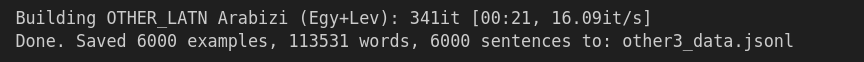

In [ ]:
from pathlib import Path
import random

inputs = [Path("other2_data.jsonl"), Path("other3_data.jsonl")]
out_path = Path("other_ar.jsonl")

all_lines = []

for inp in inputs:
    with inp.open("r", encoding="utf-8") as fin:
        for line in fin:
            line = line.strip()
            if line:
                all_lines.append(line)

random.seed(42)
random.shuffle(all_lines)

with out_path.open("w", encoding="utf-8") as fout:
    for line in all_lines:
        fout.write(line + "\n")

print("Combined & shuffled into:", out_path)


In [ ]:
from pathlib import Path
import random

inputs = [Path("other_data.jsonl"), Path("other1_data.jsonl")]
out_path = Path("other_lg.jsonl")

all_lines = []
n_ll = 0

for inp in [Path("other_data.jsonl")]:
    with inp.open("r", encoding="utf-8") as fin:
        for line in fin:
            line = line.strip()
            if line:
                all_lines.append(line)

for inp in [Path("other1_data.jsonl")]:
    with inp.open("r", encoding="utf-8") as fin:
        for line in fin:
            line = line.strip()
            if line:
                all_lines.append(line)


random.seed(42)
random.shuffle(all_lines)
n_lines = 0

with out_path.open("w", encoding="utf-8") as fout:
    for line in all_lines:
        fout.write(line + "\n")
        n_lines += 1
        if n_lines >= 20_000:
            break

print("Combined & shuffled into:", out_path)


In [ ]:
from pathlib import Path
import random

input_path = Path("other_lg.jsonl")
out_dir = Path("../../MAFT/other_lg")

train_path = out_dir / "train.jsonl"
val_path   = out_dir / "validation.jsonl"
test_path  = out_dir / "test.jsonl"

train_ratio = 0.8
val_ratio   = 0.1
test_ratio  = 0.1

out_dir.mkdir(parents=True, exist_ok=True)
random.seed(42)

n_train = n_val = n_test = 0

with input_path.open("r", encoding="utf-8") as fin, \
     train_path.open("w", encoding="utf-8") as f_train, \
     val_path.open("w", encoding="utf-8") as f_val, \
     test_path.open("w", encoding="utf-8") as f_test:

    for line in fin:
        line = line.strip()
        if not line:
            continue

        r = random.random()
        if r < train_ratio:
            f_train.write(line + "\n")
            n_train += 1
        elif r < train_ratio + val_ratio:
            f_val.write(line + "\n")
            n_val += 1
        else:
            f_test.write(line + "\n")
            n_test += 1

print("Done.")
print("train:", n_train)
print("validation:", n_val)
print("test:", n_test)


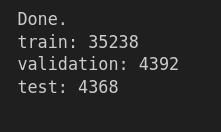